##### $\hspace{15pt}$ **Filename: anomalyDetectionOnSyntheticData.ipynb**
##### $\hspace{1.5pt}$ **Date Created: January 17, 2024**
##### **Date Modified: January 19, 2024**
##### $\rule{10.5in}{1pt}$
##### **Run anomaly detection algorithms on synthetic data consisting of two two-dimensional isotropic Gaussian blobs as inliers and uniformly distributed data points as outliers.**

##### **The content of this notebook is a variation of the following examples from `scikit-learn`: [IsolationForest example](https://scikit-learn.org/stable/auto_examples/ensemble/plot_isolation_forest.html#sphx-glr-auto-examples-ensemble-plot-isolation-forest-py) and [Comparing anomaly detection algorithms for outlier detection on toy datasets](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_anomaly_comparison.html#sphx-glr-auto-examples-miscellaneous-plot-anomaly-comparison-py)**
##### $\rule{10.5in}{1pt}$

##### Load modules and packages.

In [1]:
from sklearn.covariance import EllipticEnvelope
from sklearn.datasets import make_blobs
from sklearn.ensemble import IsolationForest
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDOneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import make_pipeline
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

##### Set the float format of pandas dataframes.

In [2]:
pd.options.display.float_format = "{:.2f}".format

##### Create data for demonstration.

In [3]:
nSamples = 300
outliersFraction = 0.15
nOutliers = int(outliersFraction*nSamples)
nInliers = nSamples - nOutliers
inliers = make_blobs(n_samples = nInliers, centers = [[2, 2], [-2, -2]], cluster_std = [1.5, 0.5], random_state = 0)
rng = np.random.RandomState(0)
outliers = rng.uniform(low = -6, high = 6, size = (nOutliers, 2))

X = np.concatenate([inliers[0], outliers])
y = np.concatenate([np.ones(nInliers, dtype = int), -np.ones(nOutliers, dtype = int)])

data = pd.DataFrame(X, columns = ["x1", "x2"])
data["true class"] = y
data.head()

,x1,x2,true class
0,-2.56,-2.37,1
1,-2.18,-1.92,1
2,-2.67,-2.67,1
3,-1.90,-2.03,1
4,5.24,4.00,1


##### Plot the data.

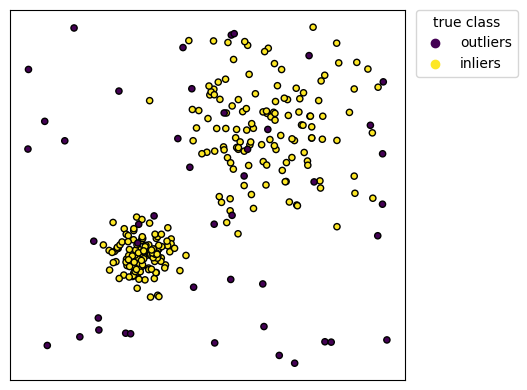

In [4]:
scatter = plt.scatter(X[:, 0], X[:, 1], s = 20, c = y, edgecolor = "k")
handles, labels = scatter.legend_elements()
plt.axis()
plt.xticks(())
plt.yticks(())
plt.legend(handles = handles, labels = ["outliers", "inliers"], title = "true class", loc = "upper left", bbox_to_anchor = (1.01, 1.02))
ax = plt.gca()
ax.set_aspect("equal", adjustable = "box")
plt.show()

##### List the algorithms to be run on the data.

In [5]:
algorithms = [("Elliptic Envelope", EllipticEnvelope(contamination = outliersFraction, random_state = 0)),
              ("Isolation Forest", IsolationForest(contamination = outliersFraction, random_state = 0)),
              ("Local Outlier Factor", LocalOutlierFactor(contamination = outliersFraction)),
              ("One-Class SVM", OneClassSVM(nu = outliersFraction)),
              ("One-Class SVM (SGD)", make_pipeline(Nystroem(random_state = 0), SGDOneClassSVM(nu = outliersFraction, random_state = 0)))]

##### Run each algorithm and determine the anomaly score and prediction for each data point.

In [6]:
for i in range(len(algorithms)):

    algorithms[i][1].fit(X)

    if algorithms[i][0] == "Local Outlier Factor":

       data[algorithms[i][0].lower() + " score"] = algorithms[i][1].negative_outlier_factor_
       data[algorithms[i][0].lower() + " prediction"] = algorithms[i][1].fit_predict(X)

    else:

       data[algorithms[i][0].lower() + " score"] = algorithms[i][1].decision_function(X)
       data[algorithms[i][0].lower() + " prediction"] = algorithms[i][1].predict(X)

data.head()

,x1,x2,true class,elliptic envelope score,elliptic envelope prediction,isolation forest score,isolation forest prediction,local outlier factor score,local outlier factor prediction,one-class svm score,one-class svm prediction,one-class svm (sgd) score,one-class svm (sgd) prediction
0,-2.56,-2.37,1,4.17,1,0.13,1,-1.05,1,0.38,1,0.02,1
1,-2.18,-1.92,1,4.52,1,0.16,1,-0.98,1,0.35,1,0.02,1
2,-2.67,-2.67,1,4.00,1,0.11,1,-1.19,1,0.39,1,0.01,1
3,-1.90,-2.03,1,4.63,1,0.16,1,-0.96,1,0.37,1,0.02,1
4,5.24,4.00,1,-0.08,-1,-0.06,-1,-1.38,1,-0.52,-1,-0.02,-1


##### Display the decision boundary determined by each algorithm except for the *Local Outlier Factor* algorithm.

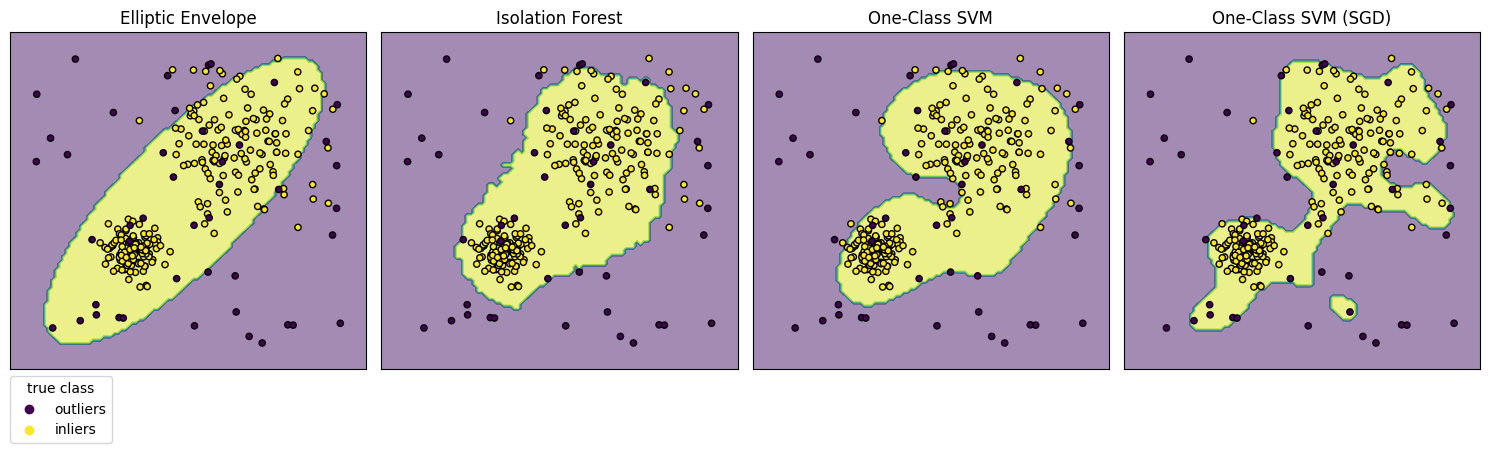

In [7]:
algorithms.pop(2)
plt.rcParams['figure.figsize'] = [15, 15]
fig, axs = plt.subplots(1, len(algorithms))

for i in range(len(algorithms)):

    disp = DecisionBoundaryDisplay.from_estimator(algorithms[i][1], X, response_method = "predict", alpha = 0.5, ax = axs[i])
    disp.ax_.scatter(X[:, 0], X[:, 1], c = y, s = 20, edgecolor = "k")
    disp.ax_.set_title(algorithms[i][0])
    axs[i].set_aspect("equal", adjustable = "box")
    axs[i].set_xticks(())
    axs[i].set_yticks(())

axs[0].legend(handles = handles, labels = ["outliers", "inliers"], title = "true class", loc = "lower left", bbox_to_anchor = (-0.02, -0.24))

fig.tight_layout()
plt.show()

##### Note: The `LocalOutlierFactor` class does not have a `predict` method which is needed by the `response_method` parameter of the `DecisionBoundaryDisplay.from_estimator` method to plot the decision boundary.